In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
Per = 1.568024
E0 = 2441374.5934

def gaus(x, a, b, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b

In [4]:
# helpfully digitized and made available here:
# http://caleb.eastern.edu/original_data_display.php?model_id=294
g75_file = 'Gyldenkerne1975.txt'

g75 = pd.read_table(g75_file, comment='#', delim_whitespace=True)

In [5]:
ubvy = (g75['d(u)'] + g75['d(b)'] + g75['d(v)'] + g75['d(y)']) / 4.

Text(0.5, 1.0, 'Gyldenkerne+1975')

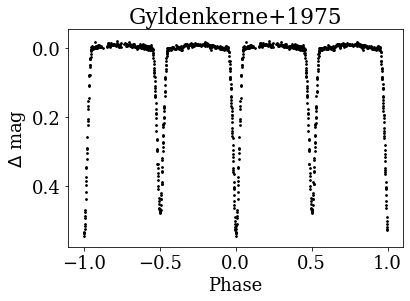

In [6]:
plt.scatter(((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per,  ubvy - np.nanmedian(ubvy), s=3, c='k')
plt.scatter(((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per - 1,  ubvy - np.nanmedian(ubvy), s=3, c='k')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$ mag')
plt.title('Gyldenkerne+1975')

[ 0.5333433  -0.00558888  0.0012955   0.01897064]


Text(0.5, 1.0, 'Gyldenkerne+1975')

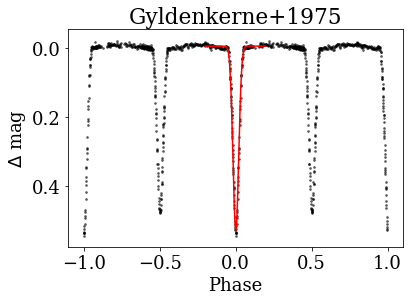

In [7]:
p0 = [0.5, 0., 0.01, 0.05]

xdata = np.hstack((((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per, 
                   ((g75['dd'] + g75['dm'] + 2440000 - E0) % Per) / Per - 1))
ydata = np.hstack((ubvy - np.nanmedian(ubvy), ubvy - np.nanmedian(ubvy)))

xr = np.where((xdata > -0.2) & (xdata < 0.2))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_g75 = fit
err_g75 = np.sqrt(np.diag(cov))

plt.scatter(xdata, ydata, s=3, c='k', alpha=0.5)
plt.plot(xdata[xr], gaus(xdata[xr], *fit), c='r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$ mag')
plt.title('Gyldenkerne+1975')

In [8]:
asassn = pd.read_csv('221524.csv')
# asassn

In [9]:
# plt.errorbar(((asassn['hjd'].values - E0) % Per)/Per, asassn['mag'] - np.nanmedian(asassn['mag']), 
#              yerr=asassn['mag err'], linestyle='none')
# plt.gca().invert_yaxis()
# plt.ylim(0.5, -0.2)
# plt.title('ASAS-SN (2014-2018)')
# plt.xlabel('Phase')
# plt.ylabel('$\Delta$V (mag)')

In [10]:
asassn2 = pd.read_csv('asassn2.csv')
# asassn2

In [11]:
# a2ok = (asassn2['mag_err'] < 0.01) & (asassn2['Filter'] == 'g')

# plt.errorbar(((asassn2['HJD'][a2ok] - E0) % Per)/Per, asassn2['mag'][a2ok], 
#              yerr=asassn2['mag_err'][a2ok], linestyle='none')
# plt.gca().invert_yaxis()
# # plt.ylim(0.5, -0.2)
# # plt.title('ASAS-SN (2014-2018)')
# plt.xlabel('Phase')
# plt.ylabel('$\Delta$V (mag)')

In [12]:
# Hipparcos light curve data (HIP 50966)
# http://cdsarc.u-strasbg.fr/viz-bin/nph-Plot/Vgraph/htm?I/239/50966&6069-1131-1
hip = pd.read_table('hipdata.txt', delimiter='|')
hip.columns

Index(['JD-2440000', ' Hpmag ', 's.e. ', 'Tflg'], dtype='object')

Text(0.5, 1.0, 'Hipparcos')

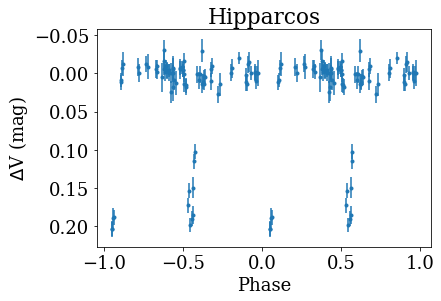

In [13]:
hok = hip['Tflg'] == 0
plt.errorbar(((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per, 
             hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]), yerr=hip['s.e. '][hok], 
             linestyle='None', marker='.', color='C0')
plt.errorbar(((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per - 1, 
             hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]), yerr=hip['s.e. '][hok], 
             linestyle='None', marker='.', color='C0')

plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$V (mag)')
plt.title('Hipparcos')

[ 0.20467056 -0.00107575  0.04981382  0.02181029]


Text(0.5, 1.0, 'Hipparcos')

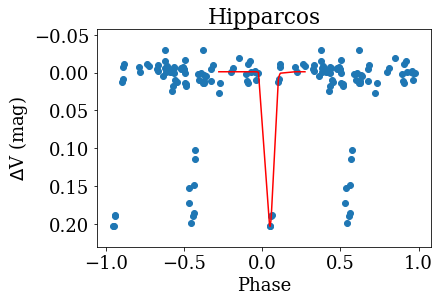

In [14]:
p0 = [0.2, 0., 0.01, 0.05]

xdata = np.hstack((((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per, 
                   ((hip['JD-2440000'][hok]+2440000 - E0) % Per) / Per - 1))
ydata = np.hstack((hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok]), hip[' Hpmag '][hok] - np.nanmedian(hip[' Hpmag '][hok])))

xr = np.where((xdata > -0.3) & (xdata < 0.3))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_hip = fit
err_hip = np.sqrt(np.diag(cov))

plt.scatter(xdata, ydata, color='C0')
plt.plot(xdata[xr], gaus(xdata[xr], *fit), c='r')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$V (mag)')
plt.title('Hipparcos')

In [15]:
asas = pd.read_table('asas3.txt', delim_whitespace=True)
asas.columns

Index(['HJD', 'MAG_4', 'MAG_0', 'MAG_1', 'MAG_2', 'MAG_3', 'MER_4', 'MER_0',
       'MER_1', 'MER_2', 'MER_3', 'GRADE', 'FRAME'],
      dtype='object')

662


(8.3, 7.9)

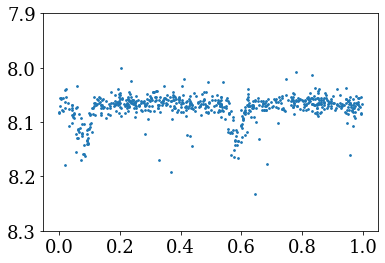

In [16]:
aok = asas['GRADE'] == 'A'
print(sum(aok))

plt.scatter(((asas['HJD'][aok] + 2450000 - E0) % Per)/Per, asas['MAG_4'][aok], s=3)
plt.ylim(8.3, 7.9)

(8.2, 8)

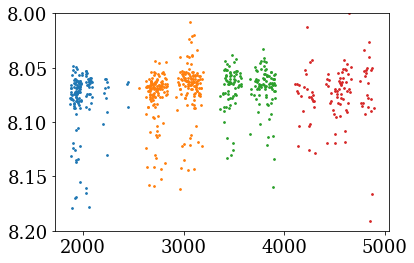

In [17]:
a1 = (asas['GRADE'] == 'A') & (asas['HJD'] < 2500)
a2 = (asas['GRADE'] == 'A') & (asas['HJD'] > 2500) & (asas['HJD'] < 3200)
a3 = (asas['GRADE'] == 'A') & (asas['HJD'] > 3200) & (asas['HJD'] < 4000)
a4 = (asas['GRADE'] == 'A') & (asas['HJD'] > 4000)

plt.scatter(asas['HJD'][a1], asas['MAG_4'][a1], s=3)
plt.scatter(asas['HJD'][a2], asas['MAG_4'][a2], s=3)
plt.scatter(asas['HJD'][a3], asas['MAG_4'][a3], s=3)
plt.scatter(asas['HJD'][a4], asas['MAG_4'][a4], s=3)
plt.ylim(8.2,8)

Text(0, 0.5, 'V (mag)')

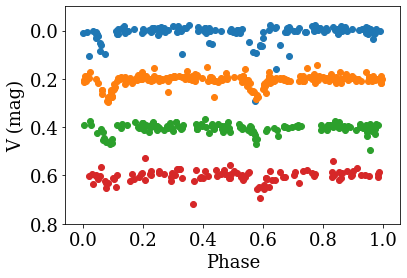

In [18]:
plt.scatter(((asas['HJD'][a1] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1]))
plt.scatter(((asas['HJD'][a2] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2])+.2)
plt.scatter(((asas['HJD'][a3] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3])+.4)
plt.scatter(((asas['HJD'][a4] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4])+.6)
plt.ylim(.8, -0.1)
plt.xlabel('Phase')
plt.ylabel('V (mag)')

[ 0.09808956 -0.00092575  0.07258907  0.01663491]
[ 0.09161375 -0.00236057  0.08031871  0.01666872]
[ 0.0755166  -0.00107478  0.08357534  0.01429624]
[ 0.03264154 -0.00708179  0.10020481  0.04287241]


Text(0, 0.5, 'V (mag)')

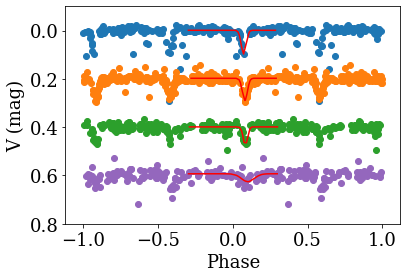

In [19]:
p0 = [0.1, 0., 0.1, 0.05]

##
xdata = np.hstack((((asas['HJD'][a1] + 2450000 - E0) % Per)/Per, 
                   ((asas['HJD'][a1] + 2450000 - E0) % Per)/Per - 1))
ydata = np.hstack((asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1]), 
                   asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1])))
xr = np.where((xdata > -0.3) & (xdata < 0.3))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_a1 = fit
err_a1 = np.sqrt(np.diag(cov))

plt.scatter(xdata, ydata)
plt.plot(xdata[xr], gaus(xdata[xr], *fit), c='r')

##
xdata = np.hstack((((asas['HJD'][a2] + 2450000 - E0) % Per)/Per, 
                   ((asas['HJD'][a2] + 2450000 - E0) % Per)/Per - 1))
ydata = np.hstack((asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2]), 
                   asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2])))
xr = np.where((xdata > -0.3) & (xdata < 0.3))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_a2 = fit
err_a2 = np.sqrt(np.diag(cov))


plt.scatter(xdata, ydata + 0.2)
plt.plot(xdata[xr], gaus(xdata[xr], *fit)+0.2, c='r')

##
xdata = np.hstack((((asas['HJD'][a3] + 2450000 - E0) % Per)/Per, 
                   ((asas['HJD'][a3] + 2450000 - E0) % Per)/Per - 1))
ydata = np.hstack((asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3]), 
                   asas['MAG_4'][a3] - np.nanmedian(asas['MAG_4'][a3])))
xr = np.where((xdata > -0.3) & (xdata < 0.3) & (ydata < 0.2))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_a3 = fit
err_a3 = np.sqrt(np.diag(cov))


plt.scatter(xdata, ydata + 0.4)
plt.plot(xdata[xr], gaus(xdata[xr], *fit)+0.4, c='r')

##
xdata = np.hstack((((asas['HJD'][a4] + 2450000 - E0) % Per)/Per, 
                   ((asas['HJD'][a4] + 2450000 - E0) % Per)/Per - 1))
ydata = np.hstack((asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4]), 
                   asas['MAG_4'][a4] - np.nanmedian(asas['MAG_4'][a4])))
xr = np.where((xdata > -0.3) & (xdata < 0.3))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_a4 = fit
err_a4 = np.sqrt(np.diag(cov))


plt.scatter(xdata, ydata+0.6, c='C4')
plt.plot(xdata[xr], gaus(xdata[xr], *fit)+0.6, c='r')

plt.ylim(.8, -0.1)
plt.xlabel('Phase')
plt.ylabel('V (mag)')

In [20]:
# plt.scatter(((asas['HJD'][a1] + 2450000 - E0) % Per)/Per, asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1]))

np.nanmax((asas['MAG_4'][a1] - np.nanmedian(asas['MAG_4'][a1]))[np.where((((asas['HJD'][a1] + 2450000 - E0) % Per)/Per < 0.2))[0]])
np.nanmax((asas['MAG_4'][a2] - np.nanmedian(asas['MAG_4'][a2]))[np.where((((asas['HJD'][a2] + 2450000 - E0) % Per)/Per < 0.2))[0]])


/Users/james/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


0.09199999999999875

In [21]:
tess_tbl = Table.read('tess2019058134432-s0009-0000000434479378-0139-s_lc.fits', format='fits')
df = tess_tbl.to_pandas()

BJD0_tess = 2457000.

Text(0.5, 1.0, 'TESS Sector 009')

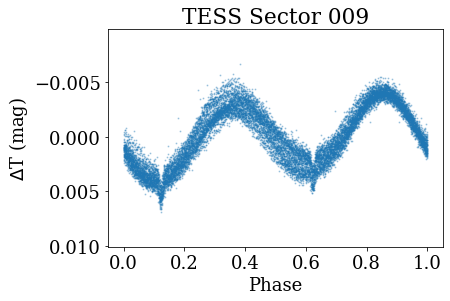

In [22]:
Tmag = -2.5*np.log10(df['PDCSAP_FLUX'])

plt.scatter(((df['TIME']+BJD0_tess-E0) % Per)/Per, Tmag - np.nanmedian(Tmag), s=1, alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('$\Delta$T (mag)')
plt.title('TESS Sector 009')

[0.00173241 0.00369946 0.19064015 0.00930672]


(0.15, 0.25)

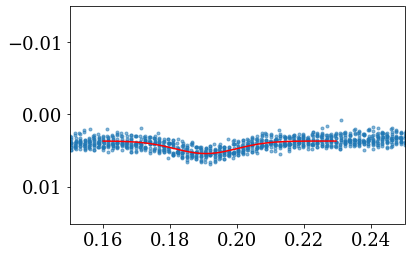

In [32]:
p0 = [0.001, 0., 0.1, 0.05]

##
xdata = (df['TIME']+BJD0_tess-E0) % Per
ydata = Tmag - np.nanmedian(Tmag)

xr = np.where((xdata > 0.16) & (xdata < 0.23) & np.isfinite(ydata))[0]
xr = xr[np.argsort(xdata[xr])]
fit, cov = curve_fit(gaus, xdata[xr], ydata[xr], p0=p0)
print(fit)
fit_tess = fit
err_tess = np.sqrt(np.diag(cov))


plt.scatter(xdata, ydata,s=9, alpha=0.53)
plt.plot(xdata[xr], gaus(xdata[xr], *fit), c='r')

# plt.scatter((df['TIME']+BJD0_tess-E0) % Per, Tmag - np.nanmedian(Tmag)-0.004)
plt.gca().invert_yaxis()
plt.xlim(0.15,0.25)
# plt.ylim(0.003,-0.003)

In [77]:
times = [np.nanmedian(g75['dd'] + g75['dm'] + 2440000 - BJD0_tess), 
         np.nanmedian(hip['JD-2440000'][hok]+2440000 - BJD0_tess),
         np.nanmedian(asas['HJD'][a1] + 2450000 - BJD0_tess),
         np.nanmedian(asas['HJD'][a2] + 2450000 - BJD0_tess),
         np.nanmedian(asas['HJD'][a3] + 2450000 - BJD0_tess),
         np.nanmedian(asas['HJD'][a4] + 2450000 - BJD0_tess),
         np.nanmedian(df['TIME'])
        ]
times = np.array(times)

In [45]:
big_data = np.vstack([fit_g75, fit_hip, fit_a1, fit_a2, fit_a3, fit_a4, fit_tess])
big_errs = np.vstack([err_g75, err_hip, err_a1, err_a2, err_a3, err_a4, err_tess])

Text(0, 0.5, '$O-C$ (Primary Ecl Phase)')

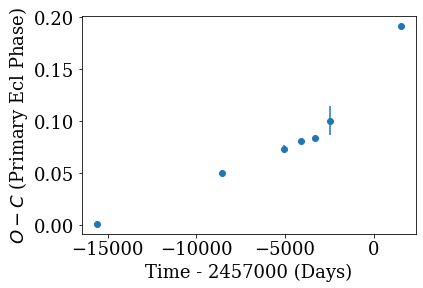

In [46]:
plt.errorbar(times, big_data[:,2], yerr=big_errs[:,2], marker='o', linestyle='None')
plt.xlabel('Time - 2457000 (Days)')
plt.ylabel('$O-C$ (Primary Ecl Phase)')

Text(0, 0.5, 'Primary Ecl Width (Days)')

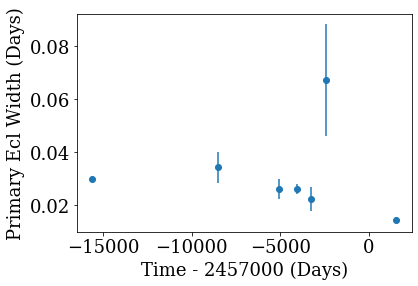

In [74]:
plt.errorbar(times, big_data[:,3]*Per, yerr=big_errs[:,3]*Per, marker='o', linestyle='None')
plt.xlabel('Time - 2457000 (Days)')
plt.ylabel('Primary Ecl Width (Days)')

Text(0, 0.5, 'Primary Ecl Depth (mag)')

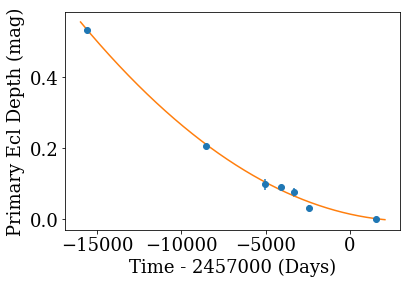

In [72]:
plt.errorbar(times, big_data[:,0], yerr=big_errs[:,0], marker='o', linestyle='None')

ff = np.polyfit(times, big_data[:,0],2, w=1./big_errs[:,0])
plt.plot(np.arange(-16000,2100), np.polyval(ff, np.arange(-16000,2100)))

plt.xlabel('Time - 2457000 (Days)')
plt.ylabel('Primary Ecl Depth (mag)')

Text(0, 0.5, 'Primary Ecl Depth (mag)')

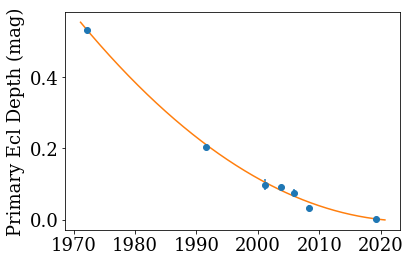

In [83]:
plt.errorbar((times+BJD0_tess - 2455197.50000)/365.24 + 2010, 
             big_data[:,0], yerr=big_errs[:,0], marker='o', linestyle='None')

plt.plot((np.arange(-16000,2100)+BJD0_tess - 2455197.50000)/365.24 + 2010, 
         np.polyval(ff, np.arange(-16000,2100)))
plt.ylabel('Primary Ecl Depth (mag)')

(2017, 2021)

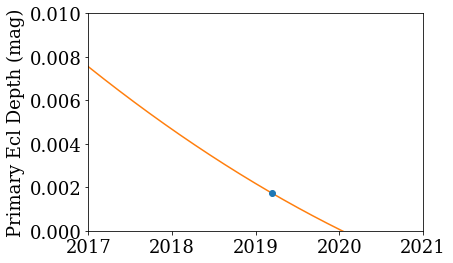

In [93]:
plt.errorbar((times+BJD0_tess - 2455197.50000)/365.24 + 2010, 
             big_data[:,0], yerr=big_errs[:,0], marker='o', linestyle='None')

plt.plot((np.arange(-16000,2100)+BJD0_tess - 2455197.50000)/365.24 + 2010, 
         np.polyval(ff, np.arange(-16000,2100)))
plt.ylabel('Primary Ecl Depth (mag)')
plt.ylim(0,0.01)
plt.xlim(2017,2021)

If this simple polynomial model is roughly correct, then HS Hya ceased eclipsing shortly after TESS observed it... sometime in early 2020 (a few weeks ago, at time of writing!). It didn't quite make it to the [2022 prediction](https://ui.adsabs.harvard.edu/abs/2012A%26A...542L..23Z/abstract), which we'll be able to verify in TESS Sector 035 in [early 2021](https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=HS+Hya).